In [249]:
validation_set_size = 128
BATCH_SIZE = 256
IMAGE_SIZE = 64
NUMBER_OF_PARTICLES = 1 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 30
NEW_MODELS=1
save_model_path = "/content/drive/My Drive/imag_n_real_feb22/"
models_path = "/content/drive/My Drive/imag_n_real_feb21/"

In [250]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tensorflow.keras import layers, models
from tensorflow.math import abs, angle, real, imag

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 25 13:25:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |    920MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [251]:
def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

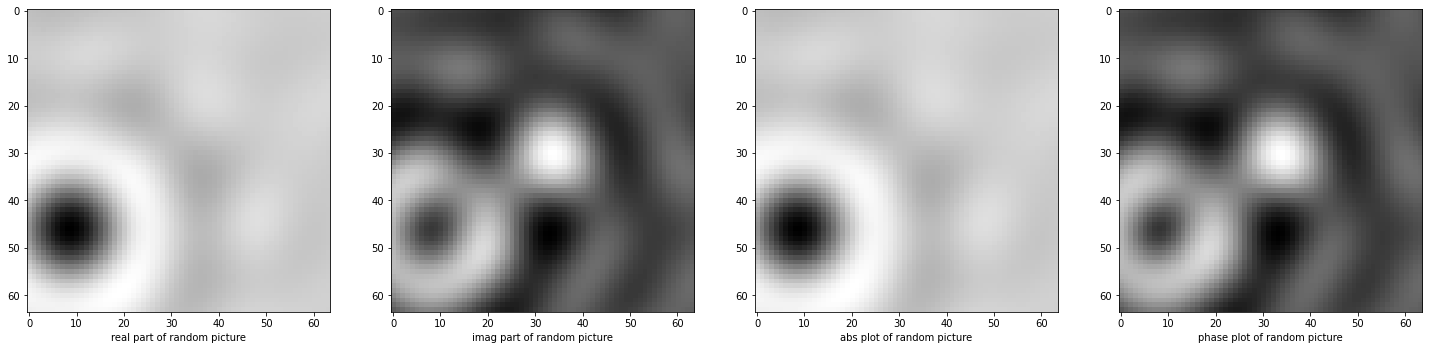

In [252]:
"""Define optics"""

particle_middle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: -Z_RANGE//2 + np.random.random() * Z_RANGE,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)


particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -(300+Z_RANGE//2)//2 + np.random.random()*(300+Z_RANGE//2),
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)
CROP = dt.Lambda(crop, pupil_radius=IMAGE_SIZE//6)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=525e-9,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC + CROP,
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.035 + np.random.rand() * 0.01,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.035j + np.random.rand() * 0.01j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-5,
)

def normalization_func():
    def inner(image):
        image = image / np.max(np.abs(image))
        return image
    return inner

def nonlinear_pxmapping():
    def inner(image):
        def sq(x):
            return x**1
        return sq(image)
    return inner

normalization = dt.Lambda(normalization_func)
nonlinear = dt.Lambda(nonlinear_pxmapping)

"""Plotting one random image and creating the dataset"""
def particles(particle):
    return particle ** max(0, round(np.random.poisson(lam=NUMBER_OF_PARTICLES)))
                                          
dataset = optics(particle_middle + particles(particle) + noise + gradient)
dataset = dt.FlipLR(dt.FlipUD(dt.FlipDiagonal(dataset)))
test_image = dataset.update().resolve()[:,:,0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,8))
ax1.imshow(np.real(test_image), cmap='gray')
ax1.set_xlabel("real part of random picture")
ax2.imshow(np.imag(test_image), cmap='gray')
ax2.set_xlabel("imag part of random picture")
ax3.imshow(np.abs(test_image), cmap='gray')
ax3.set_xlabel("abs plot of random picture")
ax4.imshow(np.angle(test_image), cmap='gray')
ax4.set_xlabel("phase plot of random picture")
plt.show()

In [253]:
"""get_label returns the z position of the middle particle, but normalized to [0,1]"""
def get_label(image):
    return np.array([image.get_property("z")])

In [254]:
class CustomLayer(keras.layers.Layer):
    "Takes a complex image as input and outputs 4 real images."

    def __init__(self):
        super().__init__()

    def build( self, input_shape):
            super().build(input_shape)

    def call(self, image):
        return tf.squeeze(tf.stack([real(image), imag(image)], axis=-1), axis=-2)

"Skapar modeller!"
if True:
    if NEW_MODELS:
        models_to_train = []
        for _ in range(2):
            model = models.Sequential()
            model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
            model.add(CustomLayer())
            model.add(layers.Conv2D(16, 7, activation='relu', strides=(4,4)))
            model.add(layers.Conv2D(32, 7, activation='relu', strides=(4,4)))
            model.add(layers.Flatten())
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dense(1))
            model.compile(optimizer='adam', loss='mae')
            model.totalhistory = {"val_loss":[], "loss":[]}
            model.specs="small"
            model.summary()
            models_to_train.append(model)
    else:
        models_to_train = load_models(models_path, 3)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_layer_50 (CustomLaye  (None, 64, 64, 2)        0         
 r)                                                              
                                                                 
 conv2d_100 (Conv2D)         (None, 15, 15, 16)        1584      
                                                                 
 conv2d_101 (Conv2D)         (None, 3, 3, 32)          25120     
                                                                 
 flatten_50 (Flatten)        (None, 288)               0         
                                                                 
 dense_100 (Dense)           (None, 32)                9248      
                                                                 
 dense_101 (Dense)           (None, 1)                 33        
                                                     

In [255]:
#@title
def _propagate_field(field, Tz, z, x, y, K, C, k=2 * np.pi / 0.633):
    """
    Propagate field. Field =  a Complex array of row*col dimension
    """
    Field = np.fft.fft2(field)
    Field = C * Tz * Field
    Field = np.fft.ifft2(Field)

    return Field


def _precalc(field, px, k=2 * np.pi / 0.633):
    """
    Precalculate some constants for propagating field for faster computations.
    """
    yr, xr = field.real.shape

    x = 2 * np.pi / px * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / px * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    # Create a circular disk here.
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return x, y, K, C


def _precalc_Tz(k, zv, K, C):
    return [C * np.fft.fftshift(np.exp(k * 1j * z * (K - 1))) for z in zv]


def propagation_matrix(
    z,
    shape=(IMAGE_SIZE, IMAGE_SIZE),
    padding=64,
    wavelength=525e-9,
    pixel_size=1.13e-6,
):

    field = np.zeros(np.array(shape) + padding * 2)
    k = 2 * np.pi / wavelength * 1e-6
    x, y, K, C = _precalc(field, pixel_size * 1e6, k)
    return _precalc_Tz(k, z, K, C)


class Rescale(dt.Feature):
    """Rescales an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, rescale=1, **kwargs):
        super().__init__(rescale=rescale, **kwargs)

    def get(self, image, rescale, **kwargs):
        image = np.array(image)
        im=image[...,0]+1j*image[...,1]
        im=(rescale*(np.abs(im)-1)+1)*np.exp(1j*np.angle(im))
        image[..., 0] = im.real
        image[..., 1] = im.imag
        return image
        

    

class RotateField(dt.Feature):
    def __init__(self, angle=0, **kwargs):
        super().__init__(angle=angle, **kwargs)

    def get(self, image, angle, **kwargs):
        image = np.array(image)
        im2=np.copy(image)
        im2[...,0]-=1
        im2[...,0]=np.cos(angle)*image[...,0]+np.sin(angle)*image[...,1]
        im2[...,1]=np.cos(angle)*image[...,1]-np.sin(angle)*image[...,0]
        image=im2
        image[...,0]+=1

        return image

    
class PhaseShift(dt.Feature):
    def __init__(self, angle=0, **kwargs):
        super().__init__(angle=angle, **kwargs)

    def get(self, image, angle, **kwargs):
        image = np.array(image)
        im2=np.copy(image)
        im2[...,0]=np.cos(angle)*image[...,0]-np.sin(angle)*image[...,1]
        im2[...,1]=np.cos(angle)*image[...,1]+np.sin(angle)*image[...,0]
        image=im2

        return image
class RescalePhase(dt.Feature):
    """Rescales the phase of an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, phasescale=1, **kwargs):
        super().__init__(phasescale=phasescale, **kwargs)

    def get(self, image, phasescale, **kwargs):
        image = np.array(image)
        im=image[...,0]+1j*image[...,1]
        im=np.abs(im)*np.exp(1j*phasescale*np.angle(im))
        return im

class FourierTransform(dt.Feature):
    """Creates matrices for propagating an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, padding=(32,32), **kwargs):
        super().__init__(padding=padding, **kwargs)

    def get(self, image, padding, **kwargs):
        im = np.copy(image)
        im = np.pad(im, (padding, padding), mode="symmetric")
        f1 = np.fft.fft2(im)
        return f1


class InverseFourierTransform(dt.Feature):
    """Creates matrices for propagating an optical field.
    Parameters
    ----------
    i : int
        index of z-propagator matrix
    """

    def __init__(self, padding=(32,32), **kwargs):
        super().__init__(padding=padding, **kwargs)

    def get(self, image, padding, **kwargs):
        im = np.fft.ifft2(image)
        return im


class FourierTransformTransformation(dt.Feature):
    def __init__(self, Tz=1, Tzinv=1, i: dt.PropertyLike[int] = 0, **kwargs):
        super().__init__(Tz=Tz, Tzinv=Tzinv, i=i, **kwargs)

    def get(self, image, Tz, Tzinv, i, **kwargs):

        if i < 0:
            propfac=1
            for j in range(int(np.abs(i))):
                propfac*=Tzinv
            image *= propfac
        else:
            propfac=1
            for j in range(int(np.abs(i))):
                propfac*=Tz
            image *= Tz ** i
        return image

def propagate(image, z):
    """Re-propagate the images using PAS"""
    image_size = len(image[:,0,0])
    propagate_up, propagate_down = propagation_matrix(
        [.05, -.05],
        shape=(image_size, image_size),
        padding=0,
        wavelength=optics.wavelength.current_value,
        pixel_size=optics.voxel_size.current_value[0],
        )
    
    ft_image = FourierTransform(padding=0).get(image, padding=0)
    prop_ft_image = FourierTransformTransformation().get(ft_image, propagate_down, propagate_up, z)
    return InverseFourierTransform(padding=0).get(prop_ft_image, padding=0)


In [256]:
"""Helper functions to visualize progress during training."""
def accuracy_of_model(model, images):
    """returns a numpy array of how much the prediction varies from what it should be, ideally containing very small values."""
    deltas = []
    for image in images:
        image = np.expand_dims(image, axis=0)
        z_ref = model.predict(image)
        for z_prop in range(-10, 10, 3): #sigma will be too low because we use model.predict to set baseline.
            z_pred = model.predict(propagate(image, z_prop))
            deltas.append(float(z_ref) + z_prop - float(z_pred)) #??
    return np.array(deltas)

def save_progress(h, validation_set, model):
    model.totalhistory["loss"].extend(h.history["loss"])     
    validation_deltas = accuracy_of_model(model, validation_set)
    std = np.std(validation_deltas)
    model.stats = {"sigma":np.round(std, decimals=3)}
    print(model.stats)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))

    ax1.plot(model.totalhistory["loss"], 'b', label="training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_yscale('log')
    ax1.legend()

    ax2.hist(validation_deltas, bins=list(np.linspace(-Z_RANGE/2,Z_RANGE/2,10*Z_RANGE)))
    ax2.set_xlabel("Pixlar från faktiskt värde")

    index = np.random.randint(len(validation_set))
    ax3.imshow(np.abs(validation_set[index])[:,:,0], cmap='gray')
    ax3.set_xlabel("abs av slumpmässig bild.")

    plt.show()

def plot_together(models):
    cc = (cycler(color=list('bgrcmykbgrcmykbgrcmykbgrcmyk')) +
      cycler(linestyle=['-','-','-','-','-','-','-','--','--','--','--','--','--','--','-.','-.','-.','-.','-.','-.','-.',':',':',':',':',':',':',':']))
    
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(moving_average(model.totalhistory["loss"], min(100, len(model.totalhistory["loss"])//4)), label=f"{model.specs}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Training loss")
        ax.set_yscale("log")
        ax.legend()

    ax.grid(True)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [257]:
"""Importing the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg


# Load a matfile with "downsized" ROI:s around particles found in the experimental data 
# Download mat-file from shared drive to your private one if to run in Colab!
drive.mount('/content/drive')
filePath = "/content/drive/My Drive/valset/valset_1.mat"

expData = mat73.loadmat(filePath)
expData = expData['CompletedTraces']

outPutShape = [64, 64]
realM = np.zeros((len(expData), 64, 64, 1))
imM = 1j * np.ones((len(expData), 64, 64, 1))
savedParticles = realM + imM

# This loop unpacks and stores all fields found in the processed video in an 3d-array
for i in range(len(expData)):

    roiData = expData[i]['ROI'][0]
    roiData = np.array(roiData)
    roiData = roiData[5, :]

    fftOfParticle = exp_expand(roiData, outPutShape)
    particleROI = np.fft.ifft2(fftOfParticle)
    particleROI = np.fft.fftshift(particleROI)
    particleROI = np.expand_dims(particleROI, axis = -1)

    savedParticles[i, :, :, :] = particleROI
    
validation_set = savedParticles[:10]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""Training all the models"""
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=BATCH_SIZE*5,
    max_data_size=BATCH_SIZE*10,
    batch_size=BATCH_SIZE,
)

for _ in range(150):
    with generator:
        for i, model in enumerate(models_to_train):
            h = model.fit(generator, epochs=5, verbose=0,)
            print(model.specs)
            save_progress(h, validation_set, model)
        plot_together(models_to_train)

Generating 1295 / 1280 samples before starting training
small


In [ ]:
"""Save models"""
save_models(models_to_train[:15])

In [ ]:
res = []
model = models_to_train[0]

for i in range(50):
    subset = [dataset.update().resolve() for _ in range(8)]
    preds = model.predict_on_batch(np.array(subset))
    actual = subset[0].get_property("z")
    mu = np.mean(preds)
    sigma = np.std(preds)
    #print(f"error: {mu-actual:.2f}, std: {sigma:.2f}")
    plt.scatter(mu-actual, sigma)
plt.show()


In [ ]:
print(int(np.array([4])))

In [ ]:
#@title
import keras

def visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8):
    """
        # Parameters:
        model: The keras model whose featuremaps are to be visualized.
        image_of_particles: The image that should be visualized.
        SUBPLOT_SIZE: The size of each individual subplot.
        SUBPLOT_WIDTH: The number of subplots to lign up horizontally. Prefferably a multiple of two.
    """
    # Plotting the two input channels (Im() and Re())
    input_fig, ax = plt.subplots(1, 2)

    ax[0].imshow(image_of_particle[:, :, 0], cmap='gray')
    ax[0].set_title("Real (?) part")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(image_of_particle[:, :, 1], cmap='gray')
    ax[1].set_title("Im (?) part")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

    # Plotting all outputs from convolutional layer, each layer is given its own figure
    IMAGE_SIZE = image_of_particle.shape[0]
    img = image_of_particle.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 2) # Reshape needed for model prediction input

    for layer in model.layers:
        if 'conv' not in layer.name: # Ignoring non-convolutional layers
            continue
        
        NUMBER_OF_OUTPUTS = layer.output.shape[3] # Total number of subplots
        SUBPLOT_HEIGHT = NUMBER_OF_OUTPUTS // SUBPLOT_WIDTH # Number of rows needed

        # Create a submodel equal to the original model but cut off at the current layer.
        submodel = keras.Model(inputs=model.inputs, outputs=layer.output)

        # Generate prediction outputs for the submodel
        feature_maps = submodel.predict(img)

        # Plotting all the outputs in a square figure

        output_number = 0
        fig, ax = plt.subplots(SUBPLOT_HEIGHT, SUBPLOT_WIDTH, figsize=(SUBPLOT_WIDTH * SUBPLOT_SIZE, SUBPLOT_HEIGHT * SUBPLOT_SIZE))
        fig.suptitle("Output of layer: " + layer.name)
        ax = ax.flatten()

        for output_number, axis in zip(range(len(ax)), ax):
            axis.imshow(feature_maps[0, :, :, output_number], cmap='gray')
            ax[output_number].set_xticks([])
            ax[output_number].set_yticks([])
                
        plt.show()

model=models[0]
image_of_particle=validation_set[0]
visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8)